In [125]:
# Python packages
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sys
import os
import pickle
import signal
import argparse
import traceback
import json
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
# Project libraries
sys.path.insert(1, '../src/')
import embedding.factory as ebd
import dataset.loader as loader
import train.factory as train_utils

I0520 17:06:23.968881 140489359800128 file_utils.py:39] PyTorch version 1.3.1 available.


In [3]:
cuda0 = torch.device('cuda:0')

# Load Data

In [5]:
PATHS_TO_ORACLE_EBD = ['20news_oracle_embed_idf.json', 'huffpost_oracle_embed_idf.json']
PATHS_TO_TOPIC_EBD = ['20news_topic_embed_.json', 'huffpost_topic_embed_.json']

PATH_TO_WIKI_EBD = 'ebd_cache.json'

In [6]:
classes_20 = [
    'mideast', 'space', 'sale', 'politics', 'graphics',
    'cryptography', 'windows', 'microsoft', 'guns',
    'religion', 'autos', 'medicine', 'mac', 'electronics',
    'hockey', 'atheism', 'motorcycles', 'pc', 'baseball', 'christian'
]

classes_h = [
    'politics', 'wellness', 'entertainment', 'travel', 'beauty', 'parenting', 'healthy', 'queer',
    'food', 'business', 'comedy', 'sports', 'black', 'home', 'parents', 'the worldpost',
    'weddings', 'women', 'impact', 'divorce', 'crime', 'media', 'weird', 'green', 'worldpost', 'religion',
    'style', 'science', 'worldnews', 'taste', 'tech', 'money', 'arts', 'fifty', 'goodnews', 'arts & culture',
    'environment', 'college', 'latino', 'culture & arts', 'education'
]

In [8]:
# Get topic or oracle embeddings
oracle_embeds = {}
for path in PATHS_TO_ORACLE_EBD:
    name = path.split('_')[0]
    with open('../cached_embeds/{}'.format(path)) as json_file:
        oracle_embeds[name] = json.load(json_file)
        
topic_embeds = {}
for path in PATHS_TO_TOPIC_EBD:
    name = path.split('_')[0]
    with open('../cached_embeds/{}'.format(path)) as json_file:
        topic_embeds[name] = json.load(json_file)

In [20]:
# Get embedding cache
with open('../{}'.format(PATH_TO_WIKI_EBD)) as json_file:
    # {(str): list of float}
    mappings = json.load(json_file)

# Visualize embeddings

We visualize embeddings by first applying a PCA to lower the number of features from 300 to 50, then by applying tSNE.

In [85]:
def PCA_(n, df):
    """
    PCAs df into n-dimensional df.
    """
    pca = PCA(n_components=n)
    pca_df = pd.DataFrame(pca.fit_transform(np.array(df).T))
    print('PCAed into shape: ', pca_df.shape)
    return pca_df

In [86]:
def tSNE(df):
    """
    t-SNEs df into 2 dimensions for visualization
    """
    print(df.shape)
    X_embed = TSNE(n_components=2).fit_transform(df)
    print('t-SNEd into shape:', X_embed.shape)
    
    return X_embed

In [94]:
def plot_embeds(embeds, names, title='tSNE Visualization of Embeddings'):
    """
    Plots embeddings with their corresponding names.
    
    embeds: N x 300 df
    
    """
    small_embeds = tSNE(PCA_(len(names), embeds)) # np array of embeddings
    
    for i, embed in enumerate(small_embeds):
        plt.scatter(embed[0], embed[1])
        plt.text(embed[0]+0.05, embed[1]-0.07, names[i], fontsize=9)
    
    plt.title(title)
    plt.show()

PCAed into shape:  (20, 20)
(20, 20)
t-SNEd into shape: (20, 2)


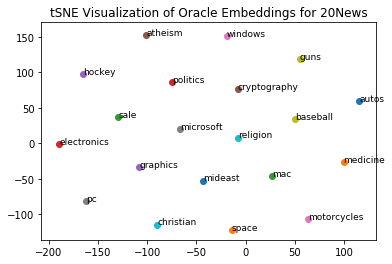

In [98]:
embeds = pd.DataFrame(oracle_embeds['20news'])
plot_embeds(embeds, classes_20, title='tSNE Visualization of Oracle Embeddings for 20News')

PCAed into shape:  (41, 41)
(41, 41)
t-SNEd into shape: (41, 2)


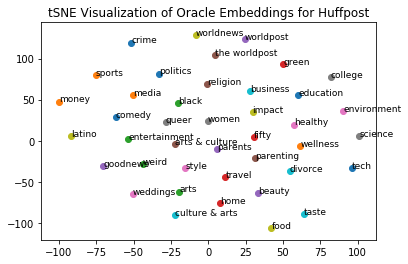

In [135]:
embeds_h = pd.DataFrame(oracle_embeds['huffpost'])
plot_embeds(embeds_h, classes_h, title='tSNE Visualization of Oracle Embeddings for Huffpost')

PCAed into shape:  (20, 20)
(20, 20)
t-SNEd into shape: (20, 2)


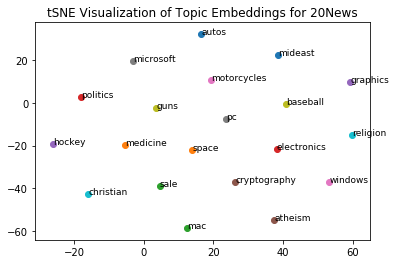

In [165]:
embedstopic = pd.DataFrame(topic_embeds['20news'])
plot_embeds(embedstopic, classes_20, title='tSNE Visualization of Topic Embeddings for 20News')

PCAed into shape:  (41, 41)
(41, 41)
t-SNEd into shape: (41, 2)


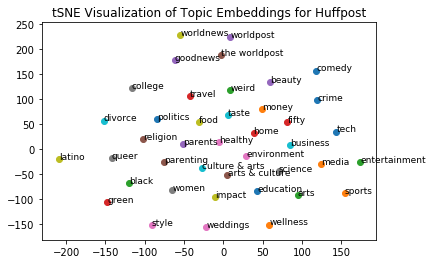

In [225]:
embedstopic_h = pd.DataFrame(topic_embeds['huffpost'])
plot_embeds(embedstopic_h, classes_h, title='tSNE Visualization of Topic Embeddings for Huffpost')

# Embeddings Distance Matrices

In [189]:
from scipy.spatial import distance_matrix
from matplotlib.pyplot import imshow
from sklearn.preprocessing import normalize


In [230]:
def plot_matrix(mat, classes, title):
    fig, ax = plt.subplots()
    im = ax.imshow(mat)
    plt.title(title)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(classes, {'fontsize':7})
    ax.set_yticklabels(classes, {'fontsize':7})
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    
    fig.colorbar(im)
    plt.show()

In [212]:
def vis_distance_matrix(df, classes, title, cos=True):
    """
    Visualize pairwise cosine distances between columns of the df.
    df should be a pandas dataframe of embedding vectors.
    """
    embeds = np.array(df).T
    
    if cos:
        embeds = normalize(embeds, norm='l2', axis=1, copy=True, return_norm=False)
    dists = distance_matrix(embeds, embeds, p=2)
#     print(dists)
#     print(np.max(dists))
    plot_matrix(dists, classes, title)
    
    return dists

In [199]:
def normalize_matrix(mat, classes, title):
    """
    Normalize matrix so it's easier to visualize
    """
    mean = np.mean(mat)
    std = np.std(mat)
    
    norm = (mat - mean)/std
    
    assert not (mat==norm).all()
    
    plot_matrix(norm, classes, title)

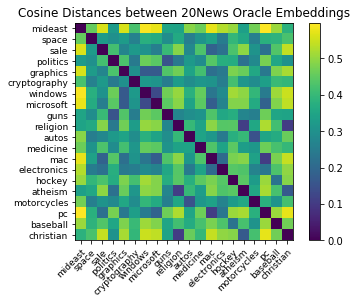

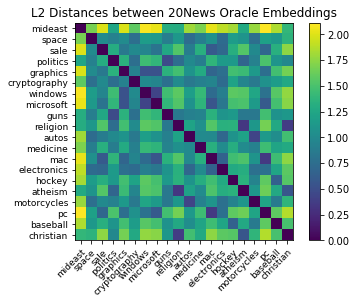

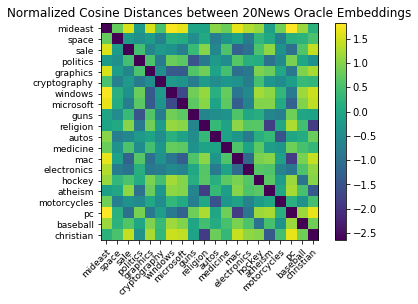

In [215]:
# Each row is a vector
dist_c20 = vis_distance_matrix(embeds, classes_20, 'Cosine Distances between 20News Oracle Embeddings')
dist_20 = vis_distance_matrix(embeds, classes_20, 'L2 Distances between 20News Oracle Embeddings', cos=False)

normalize_matrix(dist_c20, classes_20, 'Normalized Cosine Distances between 20News Oracle Embeddings')

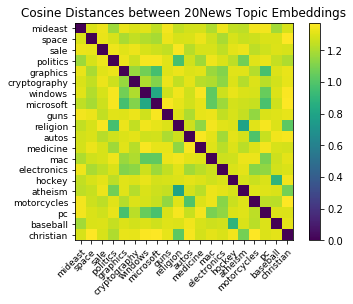

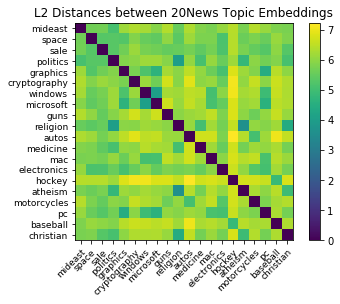

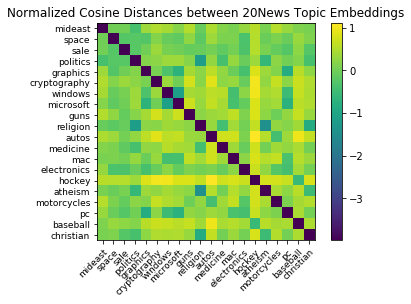

In [217]:
# Each row is a vector
dist_ct20 = vis_distance_matrix(embedstopic, classes_20, 'Cosine Distances between 20News Topic Embeddings')
dist_t20 = vis_distance_matrix(embedstopic, classes_20, 'L2 Distances between 20News Topic Embeddings', cos=False)

normalize_matrix(dist_t20, classes_20, 'Normalized Cosine Distances between 20News Topic Embeddings')

Text(0.5, 1.0, 'L2 Distances of Topic vs Oracle Embeddings')

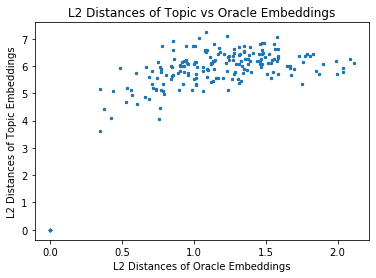

In [223]:
plt.scatter(dist_20.flatten(), dist_t20.flatten(), s=5)
plt.ylabel('L2 Distances of Topic Embeddings')
plt.xlabel('L2 Distances of Oracle Embeddings')

plt.title('L2 Distances of Topic vs Oracle Embeddings')

Text(0.5, 1.0, 'Cosine Distances of Topic vs Oracle Embeddings')

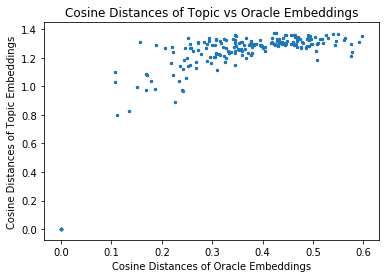

In [224]:
plt.scatter(dist_c20.flatten(), dist_ct20.flatten(), s=5)
plt.xlabel('Cosine Distances of Oracle Embeddings')
plt.ylabel('Cosine Distances of Topic Embeddings')

plt.title('Cosine Distances of Topic vs Oracle Embeddings')

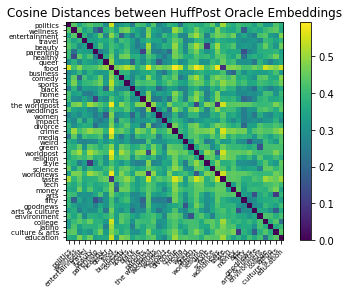

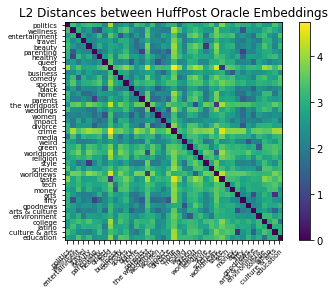

In [231]:
# Each row is a vector
dist_ch = vis_distance_matrix(embeds_h, classes_h, 'Cosine Distances between HuffPost Oracle Embeddings')
dist_h = vis_distance_matrix(embeds_h, classes_h, 'L2 Distances between HuffPost Oracle Embeddings', cos=False)


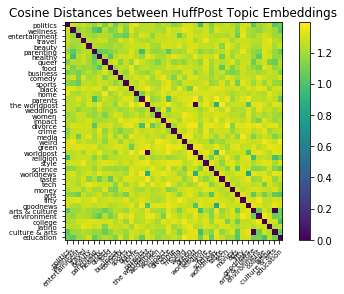

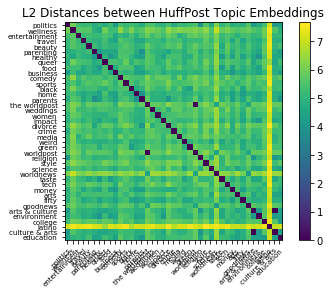

In [233]:
dist_cht = vis_distance_matrix(embedstopic_h, classes_h, 'Cosine Distances between HuffPost Topic Embeddings')
dist_ht = vis_distance_matrix(embedstopic_h, classes_h, 'L2 Distances between HuffPost Topic Embeddings', cos=False)

Text(0.5, 1.0, 'L2 Distances of HuffPost Topic vs Oracle Embeddings')

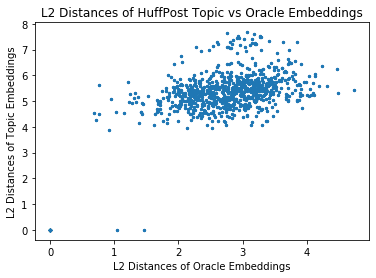

In [235]:
plt.scatter(dist_h.flatten(), dist_ht.flatten(), s=5)
plt.ylabel('L2 Distances of Topic Embeddings')
plt.xlabel('L2 Distances of Oracle Embeddings')

plt.title('L2 Distances of HuffPost Topic vs Oracle Embeddings')

Text(0.5, 1.0, 'Cosine Distances of HuffPost Topic vs Oracle Embeddings')

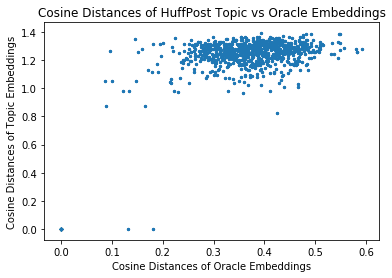

In [237]:
plt.scatter(dist_ch.flatten(), dist_cht.flatten(), s=5)
plt.xlabel('Cosine Distances of Oracle Embeddings')
plt.ylabel('Cosine Distances of Topic Embeddings')

plt.title('Cosine Distances of HuffPost Topic vs Oracle Embeddings')